<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

## Desafío 3 - Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.0 MB/s eta 0:00:00


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import gradio as gr

### Datos
Utilizo como dataset los dos libros de Don Quijote de la Mancha de Miguel de Cervantes Saavedra.

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('quijote_1_renglon.txt', sep='/n', header=None, engine='python')
df.head()

,0
0,El ingenioso hidalgo don Quijote de la Mancha
1,TASA
2,"Yo, Juan Gallo de Andrada, escribano de Cámara..."
3,"los que residen en su Consejo, certifico y doy..."
4,"compuesto por Miguel de Cervantes Saavedra, ta..."


Consideraremos que cada secuencia para este dataset es un párrafo.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los párrafos del dataset y se explorará la cantidad de términos presentes.



In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1171


### Elegir el tamaño del contexto

In [5]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [6]:
# cada renglón lo guardamos en una lista
text = list(df.loc[:,0])
text

['El ingenioso hidalgo don Quijote de la Mancha',
 'TASA',
 'Yo, Juan Gallo de Andrada, escribano de Cámara del Rey nuestro señor, de',
 'los que residen en su Consejo, certifico y doy fe que, habiendo visto por los señores dél un libro intitulado El ingenioso hidalgo de la Mancha,',
 'compuesto por Miguel de Cervantes Saavedra, tasaron cada pliego del dicho libro a tres maravedís y medio; el cual tiene ochenta y tres pliegos, que',
 'al dicho precio monta el dicho libro docientos y noventa maravedís y medio, en que se ha de vender en papel; y dieron licencia para que a este precio',
 'se pueda vender, y mandaron que esta tasa se ponga al principio del dicho libro, y no se pueda vender sin ella. Y, para que dello conste, di la',
 'presente en Valladolid, a veinte días del mes de deciembre de mil y seiscientos y cuatro años.',
 'Juan Gallo de Andrada.',
 'TESTIMONIO DE LAS ERRATAS',
 'Este libro no tiene cosa digna que no corresponda a su original; en',
 'testimonio de lo haber correcto

In [7]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence, filters='«»¡!"#$%&()*+,-./:;<=>¿?@[\\]^_`{|}~\t\n—') for sentence in text]

In [8]:
text[0]

'El ingenioso hidalgo don Quijote de la Mancha'

In [9]:
segmented_sentences[0]

['el', 'ingenioso', 'hidalgo', 'don', 'quijote', 'de', 'la', 'mancha']

In [10]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

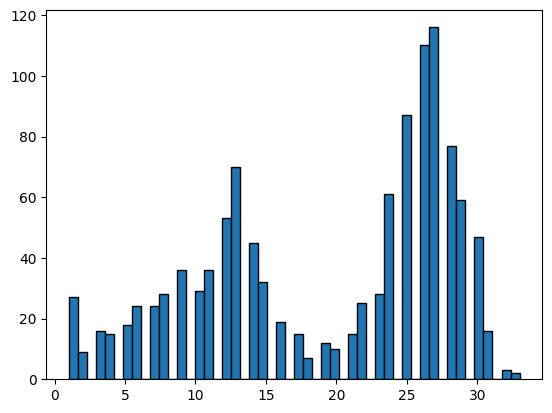

In [11]:
# podemos ver su distribución
plt.hist(length_sentences, bins=50, edgecolor='black')
plt.show()

In [12]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90) - 1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 28


###  Tokenizar

In [13]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [14]:
tokenized_sentences[0]

[5, 270, 145, 18, 20, 2, 4, 81]

In [15]:
segmented_sentences[0]

['el', 'ingenioso', 'hidalgo', 'don', 'quijote', 'de', 'la', 'mancha']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [16]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [17]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [18]:
len(tok_sent)

1011

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [19]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [20]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [21]:
train_seqs.shape

(19175, 29)

In [22]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [23]:
y.shape

(19175, 28)

In [24]:
# Palabras del vocabulario
tok.index_word

{1: 'que',
 2: 'de',
 3: 'y',
 4: 'la',
 5: 'el',
 6: 'a',
 7: 'en',
 8: 'no',
 9: 'se',
 10: 'por',
 11: 'le',
 12: 'los',
 13: 'con',
 14: 'su',
 15: 'lo',
 16: 'las',
 17: 'del',
 18: 'don',
 19: 'al',
 20: 'quijote',
 21: 'un',
 22: 'como',
 23: 'él',
 24: 'más',
 25: 'si',
 26: 'es',
 27: 'dijo',
 28: 'tan',
 29: 'sin',
 30: 'me',
 31: 'porque',
 32: 'caballero',
 33: 'ni',
 34: 'había',
 35: 'para',
 36: 'una',
 37: 'todo',
 38: 'sus',
 39: 'así',
 40: 'yo',
 41: 'era',
 42: 'vuestra',
 43: 'señor',
 44: 'mi',
 45: 'esto',
 46: 'bien',
 47: 'o',
 48: 'pero',
 49: 'cual',
 50: 'cuando',
 51: 'os',
 52: 'todos',
 53: 'libro',
 54: 'fue',
 55: 'libros',
 56: 'este',
 57: 'respondió',
 58: 'pues',
 59: 'muy',
 60: 'merced',
 61: 'cura',
 62: 'ya',
 63: 'sancho',
 64: 'aquel',
 65: 'estaba',
 66: 'otra',
 67: 'qué',
 68: 'donde',
 69: 'sino',
 70: 'sobre',
 71: 'hacer',
 72: 'quien',
 73: 'ser',
 74: 'cosa',
 75: 'ha',
 76: 'alguna',
 77: 'barbero',
 78: 'dicho',
 79: 'dos',
 80: 'mas

In [25]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4350

In [26]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'que': 1, 'de': 2, 'y': 3, 'la': 4, 'el': 5, 'a': 6, 'en': 7, 'no': 8, 'se': 9, 'por': 10, 'le': 11, 'los': 12, 'con': 13, 'su': 14, 'lo': 15, 'las': 16, 'del': 17, 'don': 18, 'al': 19, 'quijote': 20, 'un': 21, 'como': 22, 'él': 23, 'más': 24, 'si': 25, 'es': 26, 'dijo': 27, 'tan': 28, 'sin': 29, 'me': 30, 'porque': 31, 'caballero': 32, 'ni': 33, 'había': 34, 'para': 35, 'una': 36, 'todo': 37, 'sus': 38, 'así': 39, 'yo': 40, 'era': 41, 'vuestra': 42, 'señor': 43, 'mi': 44, 'esto': 45, 'bien': 46, 'o': 47, 'pero': 48, 'cual': 49, 'cuando': 50, 'os': 51, 'todos': 52, 'libro': 53, 'fue': 54, 'libros': 55, 'este': 56, 'respondió': 57, 'pues': 58, 'muy': 59, 'merced': 60, 'cura': 61, 'ya': 62, 'sancho': 63, 'aquel': 64, 'estaba': 65, 'otra': 66, 'qué': 67, 'donde': 68, 'sino': 69, 'sobre': 70, 'hacer': 71, 'quien': 72, 'ser': 73, 'cosa': 74, 'ha': 75, 'alguna': 76, 'barbero': 77, 'dicho': 78, 'dos': 79, 'mas': 80, 'mancha': 81, 'mundo': 82, 'luego': 83, 'tal': 84, 'armas': 85, 'nombre': 86

In [27]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'quijote': 129, 'mancha': 29, 'la': 415, 'hidalgo': 17, 'ingenioso': 10, 'de': 694, 'don': 140, 'el': 423, 'tasa': 4, 'escribano': 2, 'del': 168, 'juan': 8, 'andrada': 3, 'gallo': 3, 'rey': 10, 'señor': 59, 'yo': 63, 'cámara': 3, 'nuestro': 22, 'por': 226, 'certifico': 1, 'habiendo': 5, 'un': 117, 'señores': 1, 'y': 666, 'residen': 2, 'su': 213, 'dél': 6, 'fe': 5, 'consejo': 8, 'libro': 49, 'los': 214, 'intitulado': 3, 'visto': 10, 'en': 380, 'doy': 4, 'que': 719, 'cervantes': 5, 'compuesto': 4, 'tasaron': 1, 'tres': 12, 'cada': 13, 'saavedra': 2, 'maravedís': 5, 'cual': 53, 'a': 400, 'tiene': 22, 'dicho': 29, 'miguel': 4, 'ochenta': 1, 'pliego': 3, 'pliegos': 2, 'medio': 7, 'docientos': 1, 'monta': 1, 'papel': 2, 'precio': 3, 'dieron': 4, 'licencia': 5, 'noventa': 1, 'para': 72, 'se': 253, 'al': 128, 'ha': 30, 'vender': 3, 'este': 42, 'sin': 78, 'mandaron': 1, 'no': 285, 'ponga': 4, 'pueda': 6, 'dello': 2, 'principio': 11, 'di': 4, 'conste': 1, 'esta': 23, 

### Funciones a utilizar

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [28]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"{self.model_name}.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [30]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [31]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
def plot_model_history(history_ppl, model_name):
  epoch_count = range(1, len(history_ppl) + 1)
  sns.lineplot(x=epoch_count,  y=history_ppl)
  plt.title(model_name)
  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  plt.show()

In [33]:
import gradio as gr

def model_response(model, human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

def predict_with_gradio(model):
    iface = gr.Interface(
        fn=lambda text: model_response(model, text),
        inputs=["textbox"],
        outputs="text")

    iface.launch(debug=True)


### Definir el modelo 1: SimpleRNN

In [34]:
model1 = Sequential()

# Capa de embedding entrenable
model1.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# SimpleRNN
model1.add(SimpleRNN(128, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(128, return_sequences=True))
model1.add(Dropout(0.2))

# Predicción de clasificación con softmax
model1.add(Dense(vocab_size+1, activation='softmax'))

model1.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         278,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 4351)          │         561,279 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 897,343 (3.42 MB)

 Trainable params: 897,343 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [35]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl1 = []
model1_name = "SimpleRNN"
hist1 = model1.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl1, model1_name)], batch_size=64)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.1098
 mean perplexity: 18021.798028665267 

Saved new model!
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 4.1072
Epoch 2/20
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9315
 mean perplexity: 50400.6236578428 

300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 2.9306
Epoch 3/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7208
 mean perplexity: 109973.52856449745 

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.7204
Epoch 4/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5729
 mean perplexity: 75030.99777331692 

300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2.5726
Epoch 5/20
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4396
 mean perplexity: 68437.75126834489 

300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 2.4391
Epoch 6/20
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3162
 mean perplexity: 56789.77344832479 

Stopping training...
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 31m

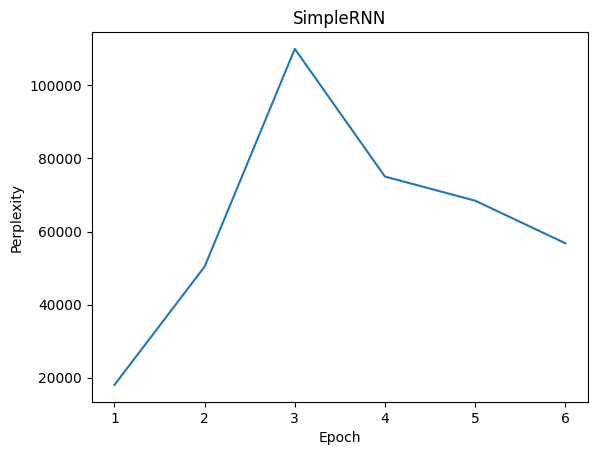

In [36]:
plot_model_history(history_ppl1, model1_name)

In [37]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model1 = keras.models.load_model(f'{model1_name}.keras')


#### Predicción de próxima palabra

In [38]:
predict_with_gradio(model1)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e112c13813ee2deb8f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e112c13813ee2deb8f.gradio.live


#### Generación de secuencias

In [39]:
input_text='en un lugar de'

generate_seq(model1, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'en un lugar de que que que que que que que que que que'

####  Beam search y muestreo aleatorio

In [41]:
temps = [1, 5, 10]
for temp in temps:
  print(f"Temperatura: {temp}")
  salidas = beam_search(model1, num_beams=3, num_words=6, input="si vuestra merced", temp=temp, mode='sto')
  for idx, salida in enumerate(salidas):
    print(f"Salida {idx + 1}: {decode(salida)}")
  print()

Temperatura: 1
Salida 1: ['si vuestra merced los del un su le he']
Salida 2: ['si vuestra merced los del un su le poco']
Salida 3: ['si vuestra merced los del un su le prometo']

Temperatura: 5
Salida 1: ['si vuestra merced don respondió del mocedad quisieron revolvía']
Salida 2: ['si vuestra merced don respondió del mocedad viuda saber']
Salida 3: ['si vuestra merced don respondió del mocedad viuda vuesa']

Temperatura: 10
Salida 1: ['si vuestra merced alcanzáredes placerdemivida llorando aparejos pasaba enderécese']
Salida 2: ['si vuestra merced doncellas tolosa procurar trapisonda llaneza dices']
Salida 3: ['si vuestra merced doncellas tolosa procurar trapisonda llaneza sudor']




### Definir el modelo 2: LSTM

In [50]:
model2 = Sequential()

# Capa de embedding entrenable
model2.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# SimpleRNN
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))

# Predicción de clasificación con softmax
model2.add(Dense(vocab_size+1, activation='softmax'))

model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 64)            │         278,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, None, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 4351)          │         561,279 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,070,143 (4.08 MB)

 Trainable params: 1,070,143 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [51]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl2 = []
model2_name = "LSTM"
hist2 = model2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl2, model2_name)], batch_size=64)

Epoch 1/20
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4199
 mean perplexity: 15517.900792176504 

Saved new model!
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 4.4141
Epoch 2/20
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0003
 mean perplexity: 16298.57899962221 

300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 3.0003
Epoch 3/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9786
 mean perplexity: 13114.162191966401 

Saved new model!
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 2.9786
Epoch 4/20
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9706
 mean perplexity: 17331.46354005819 

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.9704
Epoch 5/20
296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9458
 mean perplexity: 16246.22595531107 

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.9458
Epoch 6/20
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9624
 mean perplexity: 16796.83225360492 

300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step

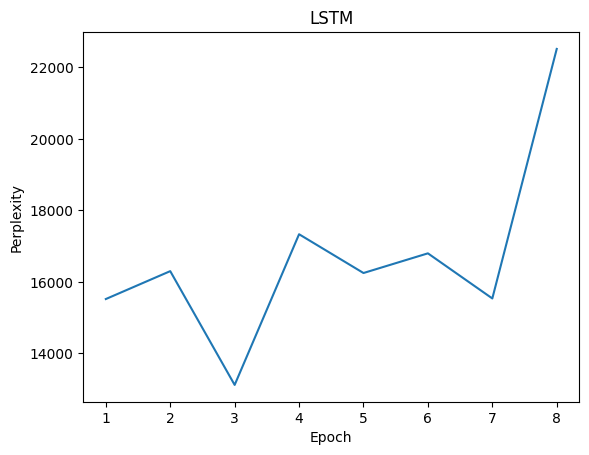

In [52]:
plot_model_history(history_ppl2, model2_name)

In [53]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model2 = keras.models.load_model(f'{model2_name}.keras')


#### Predicción de próxima palabra

In [54]:
predict_with_gradio(model2)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4be192dc007c377c3d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4be192dc007c377c3d.gradio.live


#### Generación de secuencias

In [55]:
input_text='en un lugar de'

generate_seq(model2, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'en un lugar de de de de que que que que que que que'

####  Beam search y muestreo aleatorio

In [56]:
temps = [1, 5, 10]
for temp in temps:
  print(f"Temperatura: {temp}")
  salidas = beam_search(model2, num_beams=3, num_words=6, input="si vuestra merced", temp=temp, mode='sto')
  for idx, salida in enumerate(salidas):
    print(f"Salida {idx + 1}: {decode(salida)}")
  print()

Temperatura: 1
Salida 1: ['si vuestra merced si se que de juan fatigaban']
Salida 2: ['si vuestra merced si se que de ofenden hacer']
Salida 3: ['si vuestra merced si se que de ofenden podía']

Temperatura: 5
Salida 1: ['si vuestra merced su dicha saber ése resucitara hacelde']
Salida 2: ['si vuestra merced su dicha saber andante melindroso esos']
Salida 3: ['si vuestra merced su dicha saber ése resucitara encima']

Temperatura: 10
Salida 1: ['si vuestra merced defenderme su vida mía no conocimiento']
Salida 2: ['si vuestra merced defenderme su vida mía no denuedo']
Salida 3: ['si vuestra merced defenderme su vida mía no cosmógrafo']




### Definir el modelo 3: GRU

In [57]:
model3 = Sequential()

# Capa de embedding entrenable
model3.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# SimpleRNN
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.2))

# Predicción de clasificación con softmax
model3.add(Dense(vocab_size+1, activation='softmax'))

model3.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, None, 64)            │         278,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, None, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 4351)          │         561,279 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,070,143 (4.08 MB)

 Trainable params: 1,070,143 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [58]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl3 = []
model3_name = "GRU"
hist3 = model3.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl3, model3_name)], batch_size=64)

Epoch 1/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4313
 mean perplexity: 16320.653083873542 

Saved new model!
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 4.4223
Epoch 2/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9972
 mean perplexity: 21698.438915313684 

300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 2.9972
Epoch 3/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9929
 mean perplexity: 12015.637295667942 

Saved new model!
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 2.9927
Epoch 4/20
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9731
 mean perplexity: 27410.019681029196 

300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 2.9729
Epoch 5/20
297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9581
 mean perplexity: 17835.64053893186 

300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 2.9579
Epoch 6/20
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9318
 mean perplexity: 78052.31231539046 

300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 29m

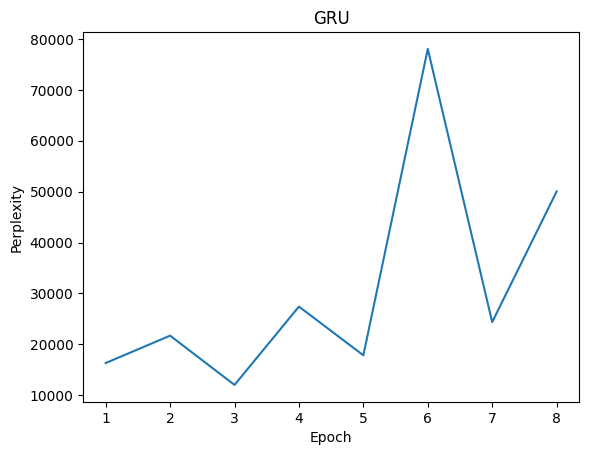

In [59]:
plot_model_history(history_ppl3, model3_name)

In [60]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model3 = keras.models.load_model(f'{model3_name}.keras')


#### Predicción de próxima palabra

In [61]:
predict_with_gradio(model3)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://aa52d67f7b0cf6b040.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://aa52d67f7b0cf6b040.gradio.live


#### Generación de secuencias

In [62]:
input_text='en un lugar de'

generate_seq(model3, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'en un lugar de que que que que que que que que que que'

####  Beam search y muestreo aleatorio

In [63]:
temps = [1, 5, 10]
for temp in temps:
  print(f"Temperatura: {temp}")
  salidas = beam_search(model3, num_beams=3, num_words=6, input="si vuestra merced", temp=temp, mode='sto')
  for idx, salida in enumerate(salidas):
    print(f"Salida {idx + 1}: {decode(salida)}")
  print()

Temperatura: 1
Salida 1: ['si vuestra merced sus que las y y della']
Salida 2: ['si vuestra merced sus que las y y se']
Salida 3: ['si vuestra merced sus que las y y viento']

Temperatura: 5
Salida 1: ['si vuestra merced batalla atar llena cala morgante babieca']
Salida 2: ['si vuestra merced batalla atar llena cala ercilla señorías']
Salida 3: ['si vuestra merced batalla atar llena cala ercilla villadie']

Temperatura: 10
Salida 1: ['si vuestra merced tasado mereciesen querer andar cuenta desdeñado']
Salida 2: ['si vuestra merced tasado mereciesen liberalidad acertó voy borró']
Salida 3: ['si vuestra merced tasado mereciesen querer andar cuenta autores']



### Conclusiones

Por limitaciones de la GPU no se pudo utilizar un corpus con un vocabulario más amplio por lo que los resultados no parecen tener demasiado sentido. Lo ideal era utilizar el libro completo pero la GPU se quedaba sin memoria. Sin embargo, se puede observar que tanto LSTM como GRU parecen generar secuencias más coherentes. Se puede ver también que generar la secuencia sin Beam Search no parece ser muy útil ya que siempre genera las mismas palabras. Algo parecido ocurre cuando se usa temperatura 1 en Beam Search ya que pareciera elegir siempre las palabras con mayor probabilidad del vocabulario.